In [11]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, DDPMScheduler, AutoencoderKL, UNet2DConditionModel
from PIL import Image
from safetensors.torch import load_file


from ip_adapter import IPAdapterPlus

In [4]:
# Путь к вашему файлу model.safetensors
ckpt_path = "/home/daniil/intSyst/weights"

# Загружаем веса
sd = load_file(f"{ckpt_path}/model.safetensors", device="cpu")

# Инициализируем словари
image_proj_sd = {}
ip_sd = {}

# Счётчик для индексации слоёв в ModuleList
ip_layer_idx = 1

# Фильтруем веса
for k in sd.keys():
	# print(k)
	if k.startswith("unet"):
		if "to_k_ip.weight" in k:
			# print(ip_layer_idx)
			# Используем нечётный индекс с префиксом ip_adapter.
			new_key = f"{ip_layer_idx}.to_k_ip.weight"
			ip_sd[new_key] = sd[k]
		elif "to_v_ip.weight" in k:
			# print(ip_layer_idx)
			new_key = f"{ip_layer_idx}.to_v_ip.weight"
			ip_sd[new_key] = sd[k]
			ip_layer_idx += 2  # Увеличиваем на 2, чтобы получить следующий нечётный индекс
	elif k.startswith("image_proj_model"):
		new_key = k.replace("image_proj_model.", "")
		image_proj_sd[new_key] = sd[k]

# Проверяем, что мы нашли веса для ip_adapter
# print("Ключи в ip_sd:", list(ip_sd.keys()))
# print("Ключи в image_proj_sd:", list(image_proj_sd.keys()))

# Сохраняем конвертированные веса
output_path = f"{ckpt_path}/ip_adapter_checkpoint-3000.bin"
torch.save({"image_proj": image_proj_sd, "ip_adapter": ip_sd}, output_path)

# print(f"Конвертированные веса сохранены в {output_path}")

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_base_folder = "output_dir/checkpoint-3000"
device = "cuda"
torch_type = torch.float16

In [ ]:
def image_grid(imgs, rows, cols):
	assert len(imgs) == rows*cols

	w, h = imgs[0].size
	grid = Image.new('RGB', size=(cols*w, rows*h))
	grid_w, grid_h = grid.size
	
	for i, img in enumerate(imgs):
		grid.paste(img, box=(i%cols*w, i//cols*h))
	return grid

# noise_scheduler = DDIMScheduler(
#     num_train_timesteps=1000,
#     beta_start=0.00085,
#     beta_end=0.012,
#     beta_schedule="scaled_linear",
#     clip_sample=False,
#     set_alpha_to_one=False,
#     steps_offset=1,
# )
noise_scheduler = DDPMScheduler.from_pretrained(base_model_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(base_model_path, subfolder="vae").to(dtype=torch_type)
trained_unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="unet"
)

In [10]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
	base_model_path,
	torch_dtype=torch_type
)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


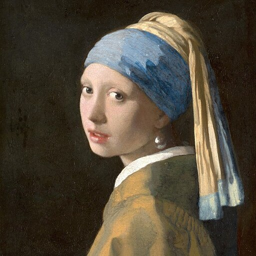

In [5]:
# read image prompt
image = Image.open("docs/assets/images/vermeer.jpg")
image.resize((256, 256))

In [ ]:
state_dict = torch.load(f"{ip_base_folder}/ip_adapter_checkpoint-3000.bin", map_location="cpu")
state_dict_base = torch.load(f"{ip_base_folder}/ip-adapter-plus_sd15.bin", map_location="cpu")
# Проверяем ключи в "ip_adapter"
# print("Ключи в ip_adapter:", list(state_dict_base["ip_adapter"].keys()))
list(state_dict["ip_adapter"].keys())

['1.to_k_ip.weight',
 '1.to_v_ip.weight',
 '3.to_k_ip.weight',
 '3.to_v_ip.weight',
 '5.to_k_ip.weight',
 '5.to_v_ip.weight',
 '7.to_k_ip.weight',
 '7.to_v_ip.weight',
 '9.to_k_ip.weight',
 '9.to_v_ip.weight',
 '11.to_k_ip.weight',
 '11.to_v_ip.weight',
 '13.to_k_ip.weight',
 '13.to_v_ip.weight',
 '15.to_k_ip.weight',
 '15.to_v_ip.weight',
 '17.to_k_ip.weight',
 '17.to_v_ip.weight',
 '19.to_k_ip.weight',
 '19.to_v_ip.weight',
 '21.to_k_ip.weight',
 '21.to_v_ip.weight',
 '23.to_k_ip.weight',
 '23.to_v_ip.weight',
 '25.to_k_ip.weight',
 '25.to_v_ip.weight',
 '27.to_k_ip.weight',
 '27.to_v_ip.weight',
 '29.to_k_ip.weight',
 '29.to_v_ip.weight',
 '31.to_k_ip.weight',
 '31.to_v_ip.weight']

In [ ]:
sd = load_file(f"{ip_base_folder}/model.safetensors", device="cpu")

# Выводим все ключи
# print("Ключи в model.safetensors:", list(sd.keys()))
list(sd.keys())

In [ ]:
sd = load_file("models/ip-adapter-plus_sd15.safetensors", device="cpu")

# Выводим все ключи
# print("Ключи в model.safetensors:", list(sd.keys()))
list(sd.keys())

In [9]:
# load ip-adapter
ip_model = IPAdapterPlus(pipe, image_encoder_path, f"{ip_base_folder}/ip_adapter_checkpoint-3000.bin", device, num_tokens=16)

RuntimeError: Error(s) in loading state_dict for ModuleList:
	size mismatch for 19.to_k_ip.weight: copying a param with shape torch.Size([1280, 768]) from checkpoint, the shape in current model is torch.Size([640, 768]).
	size mismatch for 19.to_v_ip.weight: copying a param with shape torch.Size([1280, 768]) from checkpoint, the shape in current model is torch.Size([640, 768]).
	size mismatch for 25.to_k_ip.weight: copying a param with shape torch.Size([640, 768]) from checkpoint, the shape in current model is torch.Size([320, 768]).
	size mismatch for 25.to_v_ip.weight: copying a param with shape torch.Size([640, 768]) from checkpoint, the shape in current model is torch.Size([320, 768]).
	size mismatch for 31.to_k_ip.weight: copying a param with shape torch.Size([320, 768]) from checkpoint, the shape in current model is torch.Size([1280, 768]).
	size mismatch for 31.to_v_ip.weight: copying a param with shape torch.Size([320, 768]) from checkpoint, the shape in current model is torch.Size([1280, 768]).

Проверим, что модели unet на тренировке и инференсе совпадают.

In [19]:
from diffusers import UNet2DConditionModel
unet_training = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
print(unet_training.config)

# инференсная
print(pipe.unet.config)

FrozenDict([('sample_size', 64), ('in_channels', 4), ('out_channels', 4), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D']), ('mid_block_type', 'UNetMidBlock2DCrossAttn'), ('up_block_types', ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [320, 640, 1280, 1280]), ('layers_per_block', 2), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('dropout', 0.0), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', 768), ('transformer_layers_per_block', 1), ('reverse_transformer_layers_per_block', None), ('encoder_hid_dim', None), ('encoder_hid_dim_type', None), ('attention_head_dim', 8), ('num_attention_heads', None), ('dual_cross_attention', False), ('use_linear_projection', False), ('class_embed_type', None), ('addition_emb